In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.kernel_approximation import Nystroem

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

In [2]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
model_predictions_train = pd.DataFrame()
model_predictions_train['label'] = train_df['label']
model_predictions_test = pd.DataFrame()

# Catboost predictions

In [4]:
fixed_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
}
depths = [3,6,8]
l2_leaf_regs = [1.0,3.0,6.0]

In [5]:
def generate_params():
    params = []
    for depth in depths:
        for l2_leaf_reg in l2_leaf_regs:
            param = fixed_params.copy()
            param['depth'] = depth
            param['l2_leaf_reg'] = l2_leaf_reg
            params.append(param)
    return params

def generate_model_name(params,base_name='catboost_base'):
    return f'{base_name}_{params["depth"]}_{params["l2_leaf_reg"]}'

def get_model_predictions(params=fixed_params):
    train_preds = np.zeros(train_df.shape[0])
    test_preds = np.zeros(test_df.shape[0])
    skf = StratifiedKFold(n_splits=3)
    for train_index, test_index in skf.split(train, y):
        X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
        test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
        model = CatBoostClassifier(**params)
        model.fit(X=train_pool, eval_set=test_pool,verbose=0)
        train_preds[test_index] = model.predict_proba(test_pool)[:,1]
        test_preds += model.predict_proba(submission_pool)[:,1]/3
    return train_preds,test_preds

## Base model

In [6]:
features = [
    # noise columns    
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_fare_diff_per_distance',
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_avg_speed_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare', 
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
]
cat_features = []
y = train_df['label'].values
train = train_df[features]
test = test_df[features]

submission_pool = Pool(data=test_df[features], cat_features=cat_features)

In [7]:
for params in tqdm(generate_params()):
    train_preds, test_preds = get_model_predictions(params)
    name = generate_model_name(params)
    model_predictions_train[name] = train_preds
    model_predictions_test[name] = test_preds

100%|██████████| 9/9 [01:11<00:00,  7.94s/it]


## Anomaly based predictions

In [8]:
features = [each for each in train_df.columns if 'anomaly' in each]
cat_features = features[:]
y = train_df['label'].values
train = train_df[features]
test = test_df[features]

submission_pool = Pool(data=test_df[features], cat_features=cat_features)
scale_pos_weight = (y.shape[0]-y.sum())/y.sum()

In [9]:
for params in tqdm(generate_params()):
    train_preds, test_preds = get_model_predictions(params)
    name = generate_model_name(params,'catboost_anomaly')
    model_predictions_train[name] = train_preds
    model_predictions_test[name] = test_preds

100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


# nn predictions

In [10]:
train_df = train_df.fillna(value=0)
test_df = test_df.fillna(value=0)

### autoencoder

In [11]:
features = list(filter(lambda each: ('predicted' not in each) and ('anomaly' not in each) and (each != 'label'), train_df.columns))

X = train_df[features]
Y = train_df['label']

scaler = MinMaxScaler()
x_scale = scaler.fit_transform(X)
x_correct, x_incorrect = x_scale[Y == 1], x_scale[Y == 0]

In [12]:
def get_model():
    ## input layer 
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)
    
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    
    return autoencoder

In [13]:
autoencoder = get_model()
autoencoder.fit(x_correct, x_correct, 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20,verbose=False)

In [14]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])


train = hidden_representation.predict(scaler.transform(train_df[features]))
test = hidden_representation.predict(scaler.transform(test_df[features]))
sub_pool = Pool(data=test)

In [15]:
def get_catboost_predictions(params):
    train_preds = np.zeros(train_df.shape[0])
    test_preds = np.zeros(test_df.shape[0])
    skf = StratifiedKFold(n_splits=3)
    for train_index, test_index in skf.split(train, Y):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        train_pool = Pool(data=X_train, label=y_train)
        test_pool = Pool(data=X_test, label=y_test)    
        model = CatBoostClassifier(**params)
        model.fit(X=train_pool, eval_set=test_pool,verbose=0)
        train_preds[test_index] = model.predict_proba(test_pool)[:,1]
        test_preds += model.predict_proba(sub_pool)[:,1]/3
    return train_preds,test_preds

In [16]:
for params in tqdm(generate_params()):
    train_preds, test_preds = get_catboost_predictions(params)
    name = generate_model_name(params,'autoencoder_catboost')
    model_predictions_train[name] = train_preds
    model_predictions_test[name] = test_preds

100%|██████████| 9/9 [00:34<00:00,  3.81s/it]


## simple nn

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

callbacks = [early_stopping]

def get_model(input_size,layers=[40,20,10]):
    input_layer = Input(shape=(input_size,))
    
    X = Dense(layers[0],activation='relu')(input_layer)
    for nodes in layers[1:]:
        X = Dense(nodes, activation='relu')(X)
    output_layer = Dense(1, activation='sigmoid')(X)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', 
                  loss=tfa.losses.SigmoidFocalCrossEntropy(),
                  metrics=[tfa.metrics.F1Score(num_classes=2,average='micro')])
    return model

#### Without linear predictions

In [18]:
features = list(filter(lambda each: ('predicted' not in each) and ('anomaly' not in each) and (each != 'label'), train_df.columns))

In [19]:
X = train_df[features]
y = train_df['label']
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

In [20]:
folds = 3
test_preds = np.zeros(test_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
skf = StratifiedKFold(n_splits=folds)
fold=1
for train_index, test_index in skf.split(X_scale, y):
    print('fold:',fold)
    fold += 1
    
    X_train, X_valid = X_scale[train_index], X_scale[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    model = get_model(X_train.shape[1],[100,50,50])
    model.fit(x=X_train,y=y_train,batch_size=512,epochs=100,validation_data=(X_valid,y_valid),callbacks=[callbacks])
    
    y_hat = model.predict(X_valid)
    y_hat = np.where(y_hat > 0.5,1,0)
    score = f1_score(y_valid, y_hat, average='micro')
    
    preds = model.predict(X_test).reshape(test_preds.shape)
    test_preds += preds / 3
    train_preds[test_index] += model.predict(X_valid).reshape(X_valid.shape[0])


fold: 1
Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0415 - f1_score: 0.9529 - val_loss: 0.0409 - val_f1_score: 0.9529
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0402 - f1_score: 0.9529 - val_loss: 0.0397 - val_f1_score: 0.9529
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0394 - f1_score: 0.9529 - val_loss: 0.0389 - val_f1_score: 0.9529
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0381 - f1_score: 0.9529 - val_loss: 0.0376 - val_f1_score: 0.9529
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0367 - f1_score: 0.9529 - val_loss: 0.0366 - val_f1_score: 0.9529
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0355 - f1_score: 0.9529 - val_loss: 0.0378 - val_f1_score: 0.9529
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0351 - f1_score: 0.9529 - val_loss: 0.0370 - val_f1_score: 0.9529
Epoch

Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0362 - f1_score: 0.9529 - val_loss: 0.0374 - val_f1_score: 0.9530
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0351 - f1_score: 0.9529 - val_loss: 0.0383 - val_f1_score: 0.9530
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0345 - f1_score: 0.9529 - val_loss: 0.0351 - val_f1_score: 0.9530
Epoch 8/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0329 - f1_score: 0.9529 - val_loss: 0.0351 - val_f1_score: 0.9530
Epoch 9/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0325 - f1_score: 0.9529 - val_loss: 0.0344 - val_f1_score: 0.9530
Epoch 10/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0321 - f1_score: 0.9529 - val_loss: 0.0341 - val_f1_score: 0.9530
Epoch 11/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0310 - f1_score: 0.9529 - val_loss: 0.0333 - val_f1_score: 0.9530
Epoch 12/10

In [21]:
name = 'simple_nn'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

#### with linear predictions

In [22]:
features = list(filter(lambda each: ('anomaly' not in each) and (each != 'label'), train_df.columns))
X = train_df[features]
y = train_df['label']
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

In [23]:
folds = 3
test_preds = np.zeros(test_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
skf = StratifiedKFold(n_splits=folds)
fold=1
for train_index, test_index in skf.split(X_scale, y):
    print('fold:',fold)
    fold += 1
    
    X_train, X_valid = X_scale[train_index], X_scale[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    model = get_model(X_train.shape[1],[100,50,50])
    model.fit(x=X_train,y=y_train,batch_size=512,epochs=100,validation_data=(X_valid,y_valid),callbacks=[callbacks])
    
    y_hat = model.predict(X_valid)
    y_hat = np.where(y_hat > 0.5,1,0)
    score = f1_score(y_valid, y_hat, average='micro')
    
    preds = model.predict(X_test).reshape(test_preds.shape)
    test_preds += preds / 3
    train_preds[test_index] += model.predict(X_valid).reshape(X_valid.shape[0])


fold: 1
Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0406 - f1_score: 0.9529 - val_loss: 0.0410 - val_f1_score: 0.9529
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0397 - f1_score: 0.9529 - val_loss: 0.0396 - val_f1_score: 0.9529
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0397 - f1_score: 0.9529 - val_loss: 0.0390 - val_f1_score: 0.9529
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0384 - f1_score: 0.9529 - val_loss: 0.0378 - val_f1_score: 0.9529
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0371 - f1_score: 0.9529 - val_loss: 0.0369 - val_f1_score: 0.9529
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0362 - f1_score: 0.9529 - val_loss: 0.0372 - val_f1_score: 0.9529
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0348 - f1_score: 0.9529 - val_loss: 0.0351 - val_f1_score: 0.9529
Epoch

Epoch 34/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0268 - f1_score: 0.9529 - val_loss: 0.0286 - val_f1_score: 0.9529
Epoch 35/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0271 - f1_score: 0.9529 - val_loss: 0.0383 - val_f1_score: 0.9529
fold: 3
Epoch 1/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0444 - f1_score: 0.9529 - val_loss: 0.0410 - val_f1_score: 0.9530
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0402 - f1_score: 0.9529 - val_loss: 0.0408 - val_f1_score: 0.9530
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0396 - f1_score: 0.9529 - val_loss: 0.0403 - val_f1_score: 0.9530
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0385 - f1_score: 0.9529 - val_loss: 0.0392 - val_f1_score: 0.9530
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0377 - f1_score: 0.9529 - val_loss: 0.0377 - val_f1_score: 0.9530
Epo

In [24]:
name = 'simple_nn_with_linear_predictions'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Multihead

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


BATCH_SIZE = 512

STEPS_PER_EPOCH = 3400//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=STEPS_PER_EPOCH*1000,
      decay_rate=1,
      staircase=False)

def get_log_dir(model):
    model_name = '-'.join(map(lambda x: str(x),model))
    return f'./logs/{model_name}'

callbacks = [early_stopping]

def get_combined_model(fare_model, duration_model, meter_waiting_model, meter_waiting_fare_model, model_def=[100,50], freeze_input=True):
    if freeze_input:
        fare_model.trainable = False
        duration_model.trainable = False
        meter_waiting_model.trainable = False
        meter_waiting_fare_model.trainable = False
    
    fare_input = Input(shape=(fare_model.input.shape[1],), name='fare_input')
    fare = fare_model(fare_input)
    
    duration_input = Input(shape=(duration_model.input.shape[1],), name='duration_input')
    duration = fare_model(duration_input)
    
    meter_waiting_input = Input(shape=(meter_waiting_model.input.shape[1],), name='meter_waiting_input')
    meter_waiting = fare_model(meter_waiting_input)
    
    meter_waiting_fare_input = Input(shape=(meter_waiting_fare_model.input.shape[1],), name='meter_waiting_fare_input')
    meter_waiting_fare = fare_model(meter_waiting_fare_input)
    
    X = concatenate([fare,duration,meter_waiting,meter_waiting_fare])
    
    for nodes in model_def:
        X = Dense(nodes, activation='relu')(X)
    output_layer = Dense(1, activation='sigmoid')(X)
    
    model = Model([fare_input,duration_input,meter_waiting_input,meter_waiting_fare_input],output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), 
                  loss=tfa.losses.SigmoidFocalCrossEntropy(),
                  metrics=[tfa.metrics.F1Score(num_classes=2,average='micro')])
    return model

In [26]:
fare_representation = tf.keras.models.load_model('models/fare_representation')
duration_representation = tf.keras.models.load_model('models/duration_representation')
meter_waiting_representation = tf.keras.models.load_model('models/meter_waiting_representation')
meter_waiting_fare_representation = tf.keras.models.load_model('models/meter_waiting_fare_representation')

In [27]:
features = [
    'additional_fare', 
    'duration', 
    'meter_waiting', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'fare',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference'
]

fare_features = ['additional_fare', 
    'duration', 
    'meter_waiting', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

duration_features = ['additional_fare', 
    'meter_waiting', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'fare',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

meter_waiting_features = ['additional_fare', 
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'fare',
    'duration',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

meter_waiting_fare_features = ['additional_fare', 
    'meter_waiting',    
    'meter_waiting_till_pickup', 
    'fare',
    'duration',
    'pickup_date', 
    'pickup_hour', 
    'pickup_minute',
    'drop_date', 
    'drop_hour', 
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference']

In [28]:
X = train_df[features]
y = train_df['label']
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

train = train_df.copy()
train[features] = X_scale

test = test_df.copy()
test[features] = X_test

In [29]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()
tf.random.set_seed(0)

folds = 3

model_def=(400, 800, 400, 100, 50, 20, 10)
test_preds = np.zeros(test_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
skf = StratifiedKFold(n_splits=folds)
fold=1
for train_index, test_index in skf.split(train, y):
    print('fold:',fold)
    fold += 1
    
    X_fare_train, X_fare_test = train[fare_features].iloc[train_index,:],train[fare_features].iloc[test_index,:]
    X_duration_train, X_duration_test = train[duration_features].iloc[train_index,:],train[duration_features].iloc[test_index,:]
    X_meter_waiting_train, X_meter_waiting_test = train[meter_waiting_features].iloc[train_index,:],train[meter_waiting_features].iloc[test_index,:]
    X_meter_waiting_fare_train, X_meter_waiting_fare_test = train[meter_waiting_fare_features].iloc[train_index,:],train[meter_waiting_fare_features].iloc[test_index,:]
    
    y_train, y_valid = y[train_index], y[test_index]
    model = get_combined_model(fare_representation,
                           duration_representation,
                           meter_waiting_representation,
                           meter_waiting_fare_representation,
                           model_def=model_def)
    model.fit({'fare_input':X_fare_train,
              'duration_input':X_duration_train,
              'meter_waiting_input':X_meter_waiting_train,
              'meter_waiting_fare_input':X_meter_waiting_fare_train},
              y_train,
              batch_size=512,
              epochs=500,
              validation_data=({'fare_input':X_fare_test,
              'duration_input':X_duration_test,
              'meter_waiting_input':X_meter_waiting_test,
              'meter_waiting_fare_input':X_meter_waiting_fare_test},y_valid),callbacks=callbacks)
    y_hat = model.predict({'fare_input':X_fare_test,
              'duration_input':X_duration_test,
              'meter_waiting_input':X_meter_waiting_test,
              'meter_waiting_fare_input':X_meter_waiting_fare_test}).reshape(y_valid.shape)
    train_preds[test_index] = y_hat
 
    X_fare, X_duration, X_meter_waiting,X_X_meter_waiting_fare = test[fare_features],test[duration_features],test[meter_waiting_features],test[meter_waiting_fare_features]
    
    preds = model.predict({'fare_input':X_fare,
              'duration_input':X_duration,
              'meter_waiting_input':X_meter_waiting,
              'meter_waiting_fare_input':X_X_meter_waiting_fare}).reshape(test_preds.shape)
    test_preds += preds/3

fold: 1
Epoch 1/500
23/23 [==============================] - 1s 42ms/step - loss: 0.1081 - f1_score: 0.9530 - val_loss: 0.1236 - val_f1_score: 0.9532
Epoch 2/500
23/23 [==============================] - 1s 31ms/step - loss: 0.0592 - f1_score: 0.9530 - val_loss: 0.0579 - val_f1_score: 0.9531
Epoch 3/500
23/23 [==============================] - 1s 31ms/step - loss: 0.0417 - f1_score: 0.9529 - val_loss: 0.0368 - val_f1_score: 0.9529
Epoch 4/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0365 - f1_score: 0.9529 - val_loss: 0.0359 - val_f1_score: 0.9529
Epoch 5/500
23/23 [==============================] - 1s 31ms/step - loss: 0.0353 - f1_score: 0.9529 - val_loss: 0.0346 - val_f1_score: 0.9529
Epoch 6/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0324 - f1_score: 0.9529 - val_loss: 0.0445 - val_f1_score: 0.9529
Epoch 7/500
23/23 [==============================] - 1s 30ms/step - loss: 0.0334 - f1_score: 0.9529 - val_loss: 0.0503 - val_f1_score: 0.952

In [30]:
name = 'multihead_nn'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# LightGBM

In [35]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='micro'), True


## all features

In [34]:
features = list(filter(lambda each: ('anomaly' not in each) and (each != 'label'), train_df.columns))
train_X = train_df[features]
test_X = test_df[features]
y = train_df['label']

In [36]:
params = {
    'bagging_fraction': 0.7528277381788788,
    'class_weight': None,
    'feature_fraction': 0.5625261317624038,
    'lambda_l2_positive': 0.01363014388342585,
    'learning_rate': 0.11231814419878085,
    'min_child_weight': 20.69211631593017,
    'min_data_in_leaf': 5,
    'num_leaves': 86,
    'subsample_for_bin': 60000
}


In [37]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
test_preds = np.zeros(test_X.shape[0])
train_preds = np.zeros(train_X.shape[0])
for train_index, test_index in skf.split(train_df, y):
    X_train, X_test = train_X.iloc[train_index,:], train_X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train = lgb.Dataset(X_train,y_train)
    valid = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(params, train,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test_X) / 3
    train_preds[test_index] = model.predict(X_test)

In [38]:
name = 'lgb_all'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Catboost features

In [42]:
features = [
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_fare_diff_per_distance',
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_avg_speed_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare', 
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
]
train_X = train_df[features]
test_X = test_df[features]

In [43]:
params = {
    'bagging_fraction': 0.9582184397618998,
    'class_weight': 'balanced',
    'feature_fraction': 0.6584730253641345,
    'lambda_l1_positive': 0.004131014051823846,
    'lambda_l2_positive': 2.021463074958273,
    'learning_rate': 0.1292032123987036,
    'min_child_weight': 27.329223863721854,
    'min_data_in_leaf': 3,
    'num_leaves': 120,
    'subsample_for_bin': 20000
}

In [44]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
test_preds = np.zeros(test_X.shape[0])
train_preds = np.zeros(train_X.shape[0])
for train_index, test_index in skf.split(train_df, y):
    X_train, X_test = train_X.iloc[train_index,:], train_X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train = lgb.Dataset(X_train,y_train)
    valid = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(params, train,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test_X) / 3
    train_preds[test_index] = model.predict(X_test)

In [45]:
name = 'lgb_catfeatures'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

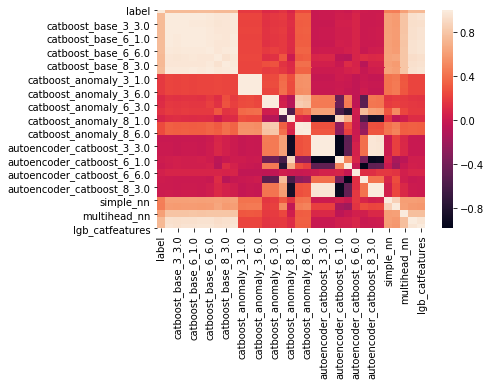

In [47]:
sns.heatmap(model_predictions_train.corr())

In [46]:
model_predictions_train.to_csv('stack_train.csv',index=False)
model_predictions_test.to_csv('stack_test.csv',index=False)

# Catboost stack

In [29]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

In [30]:
features = model_predictions_test.columns
cat_features = []

In [18]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1'    
}

In [19]:
submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]
labels = model_predictions_train['label']

In [20]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

Learning rate set to 0.057693
0:	learn: 0.9752535	test: 0.9784450	best: 0.9784450 (0)	total: 14.2ms	remaining: 14.2s
10:	learn: 0.9755605	test: 0.9785921	best: 0.9785921 (10)	total: 52.4ms	remaining: 4.71s
20:	learn: 0.9755722	test: 0.9782232	best: 0.9787931 (12)	total: 90.2ms	remaining: 4.2s
30:	learn: 0.9759007	test: 0.9779235	best: 0.9787931 (12)	total: 127ms	remaining: 3.96s
40:	learn: 0.9760770	test: 0.9779149	best: 0.9787931 (12)	total: 163ms	remaining: 3.81s
50:	learn: 0.9761733	test: 0.9777264	best: 0.9787931 (12)	total: 205ms	remaining: 3.82s
60:	learn: 0.9763635	test: 0.9774306	best: 0.9787931 (12)	total: 254ms	remaining: 3.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9787931367
bestIteration = 12

Shrink model to first 13 iterations.
Validation f1 0.9787931366878735
Learning rate set to 0.057693
0:	learn: 0.9724521	test: 0.9725559	best: 0.9725559 (0)	total: 25.4ms	remaining: 25.4s
10:	learn: 0.9758938	test: 0.9787111	best: 0.9787152 (9)	total: 84ms

In [21]:
np.mean(validation_scores), np.std(validation_scores)

(0.976582618978218, 0.003219170994646158)

In [11]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,catboost_base_6_3.0,12.647012
1,catboost_base_6_1.0,6.316308
2,catboost_base_3_1.0,5.846901
3,autoencoder_catboost_8_1.0,5.468975
4,autoencoder_catboost_6_1.0,5.232470
5,lgb_all,4.725591
6,catboost_base_3_3.0,4.546237
7,catboost_base_8_3.0,4.345538
8,catboost_base_6_6.0,4.153760
9,catboost_base_3_6.0,4.135317


In [15]:
submission_df['prediction'] = np.where(submission_preds > 0.5, 1, 0)
submission_df.to_csv('submission.csv',index=False)

### Limited features

In [91]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]
cat_features = []

submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]
labels = model_predictions_train['label']

In [92]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [93]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

Learning rate set to 0.057693
0:	learn: 0.9729292	test: 0.9695417	best: 0.9695417 (0)	total: 10.6ms	remaining: 10.6s
10:	learn: 0.9755441	test: 0.9785714	best: 0.9788095 (7)	total: 68.8ms	remaining: 6.19s
20:	learn: 0.9761493	test: 0.9779022	best: 0.9788095 (7)	total: 108ms	remaining: 5.05s
30:	learn: 0.9759523	test: 0.9779064	best: 0.9788095 (7)	total: 140ms	remaining: 4.36s
40:	learn: 0.9761870	test: 0.9777135	best: 0.9788095 (7)	total: 170ms	remaining: 3.98s
50:	learn: 0.9760862	test: 0.9777135	best: 0.9788095 (7)	total: 203ms	remaining: 3.77s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9788094779
bestIteration = 7

Shrink model to first 8 iterations.
Validation f1 0.978809477942593
Learning rate set to 0.057693
0:	learn: 0.9718214	test: 0.9701419	best: 0.9701419 (0)	total: 3.46ms	remaining: 3.46s
10:	learn: 0.9753657	test: 0.9790385	best: 0.9796783 (4)	total: 35ms	remaining: 3.15s
20:	learn: 0.9757599	test: 0.9784533	best: 0.9796783 (4)	total: 66.8ms	remaini

In [94]:
np.mean(validation_scores), np.std(validation_scores)

(0.9773568403296352, 0.002692173174336035)

In [95]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,catboost_base_6_3.0,48.495452
1,lgb_catfeatures,21.102987
2,lgb_all,18.975519
3,catboost_base_3_1.0,5.543193
4,simple_nn_with_linear_predictions,4.197247
5,multihead_nn,0.973950
6,autoencoder_catboost_8_1.0,0.711653
7,simple_nn,0.000000
8,catboost_anomaly_3_6.0,0.000000


In [96]:
worst_model = models[np.argmin(validation_scores)]
worst_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,catboost_base_6_3.0,50.279733
1,lgb_catfeatures,37.208726
2,simple_nn_with_linear_predictions,8.424649
3,multihead_nn,4.086892
4,catboost_base_3_1.0,0.000000
5,autoencoder_catboost_8_1.0,0.000000
6,lgb_all,0.000000
7,simple_nn,0.000000
8,catboost_anomaly_3_6.0,0.000000


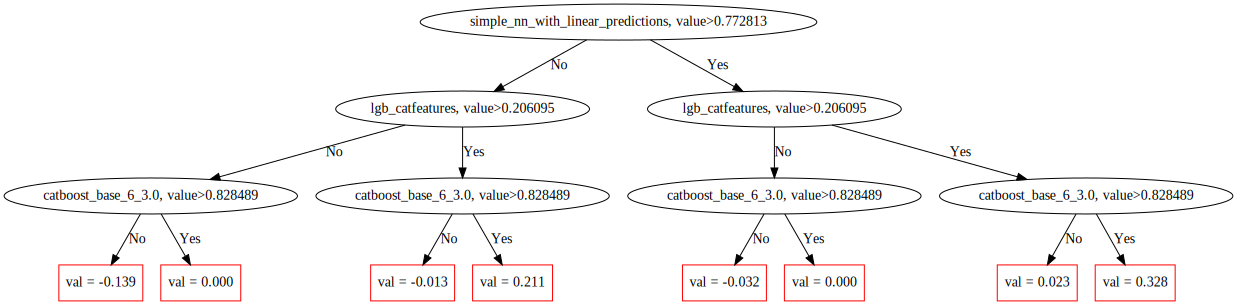

In [97]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

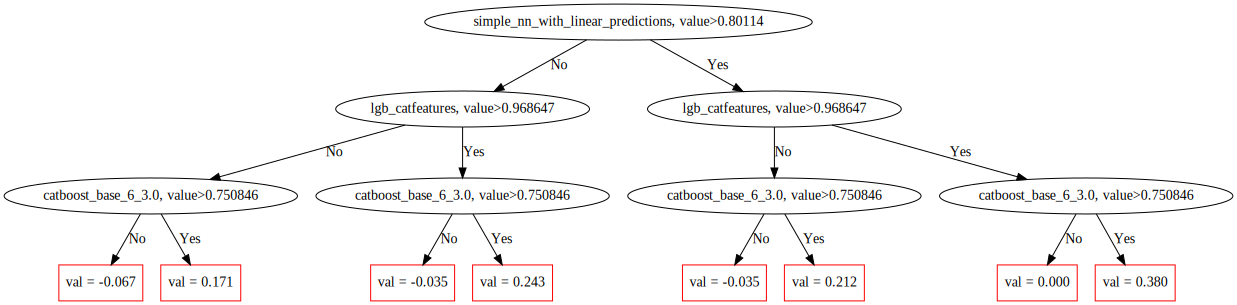

In [98]:
worst_model.plot_tree(0,train_pools[np.argmin(validation_scores)])

In [99]:
predictions_df = pd.DataFrame()

predictions_df['target'] = labels
predictions_df['worst_model'] = worst_model.predict(train)
predictions_df['best_model'] = best_model.predict(train)

predictions_df['worst_incorrect'] = np.abs(predictions_df['target']-predictions_df['worst_model'])
predictions_df['best_incorrect'] = np.abs(predictions_df['target']-predictions_df['best_model'])

In [100]:
predictions_df

,target,worst_model,best_model,worst_incorrect,best_incorrect
0,1,1,1,0,0
1,1,1,1,0,0
2,1,1,1,0,0
3,1,1,1,0,0
4,1,1,1,0,0
...,...,...,...,...,...
16962,1,1,1,0,0
16963,1,1,1,0,0
16964,1,1,1,0,0
16965,1,1,1,0,0


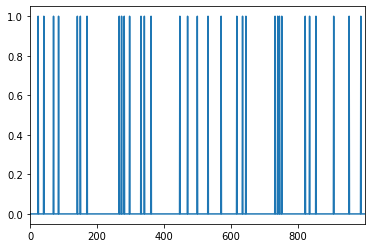

In [101]:
predictions_df['worst_incorrect'][:1_000].plot()

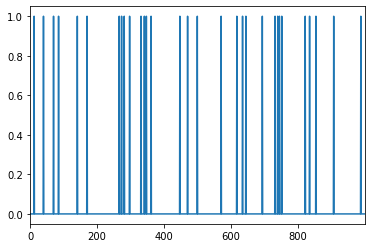

In [102]:
predictions_df['best_incorrect'][:1_000].plot()

In [103]:
submission_df['prediction'] = np.where(submission_preds > 0.5, 1, 0)
submission_df.to_csv('submission.csv',index=False)

### Meta predictions feature engineerings

All the features

In [73]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = list(model_predictions_test.columns)

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

cat_features = []

submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]
labels = model_predictions_train['label']

In [74]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [75]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

Learning rate set to 0.057693
0:	learn: 0.9756144	test: 0.9782129	best: 0.9782129 (0)	total: 14.8ms	remaining: 14.8s
10:	learn: 0.9760862	test: 0.9786412	best: 0.9791586 (7)	total: 152ms	remaining: 13.6s
20:	learn: 0.9759546	test: 0.9792371	best: 0.9792731 (13)	total: 303ms	remaining: 14.1s
30:	learn: 0.9765854	test: 0.9783617	best: 0.9792731 (13)	total: 439ms	remaining: 13.7s
40:	learn: 0.9770082	test: 0.9784728	best: 0.9792731 (13)	total: 595ms	remaining: 13.9s
50:	learn: 0.9770485	test: 0.9783282	best: 0.9792731 (13)	total: 736ms	remaining: 13.7s
60:	learn: 0.9774740	test: 0.9781347	best: 0.9792731 (13)	total: 894ms	remaining: 13.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9792731129
bestIteration = 13

Shrink model to first 14 iterations.
Validation f1 0.9792731128892316
Learning rate set to 0.057693
0:	learn: 0.9722033	test: 0.9744586	best: 0.9744586 (0)	total: 15.7ms	remaining: 15.7s
10:	learn: 0.9756637	test: 0.9789160	best: 0.9789160 (10)	total: 151ms

In [76]:
np.mean(validation_scores), np.std(validation_scores)

(0.9768509093174295, 0.0032889966427613383)

limited features

In [87]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]
labels = model_predictions_train['label']
model_predictions_train = model_predictions_train[features]
model_predictions_test = model_predictions_test[features]

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

cat_features = []

submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)
train = model_predictions_train[features]

In [88]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'depth':3
}

In [89]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

Learning rate set to 0.057693
0:	learn: 0.9742798	test: 0.9773013	best: 0.9773013 (0)	total: 12.3ms	remaining: 12.3s
10:	learn: 0.9756637	test: 0.9778851	best: 0.9783617 (8)	total: 56.3ms	remaining: 5.06s
20:	learn: 0.9760977	test: 0.9781811	best: 0.9783617 (8)	total: 95ms	remaining: 4.43s
30:	learn: 0.9764779	test: 0.9780740	best: 0.9783742 (23)	total: 131ms	remaining: 4.09s
40:	learn: 0.9764779	test: 0.9779838	best: 0.9783742 (23)	total: 171ms	remaining: 3.99s
50:	learn: 0.9768717	test: 0.9779880	best: 0.9783742 (23)	total: 232ms	remaining: 4.32s
60:	learn: 0.9770552	test: 0.9779880	best: 0.9783742 (23)	total: 271ms	remaining: 4.17s
70:	learn: 0.9772432	test: 0.9775975	best: 0.9783742 (23)	total: 311ms	remaining: 4.07s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9783742035
bestIteration = 23

Shrink model to first 24 iterations.
Validation f1 0.978374203514192
Learning rate set to 0.057693
0:	learn: 0.9745198	test: 0.9757846	best: 0.9757846 (0)	total: 15.8ms	r

In [90]:
np.mean(validation_scores), np.std(validation_scores)

(0.9768909308106797, 0.0028563899976401363)

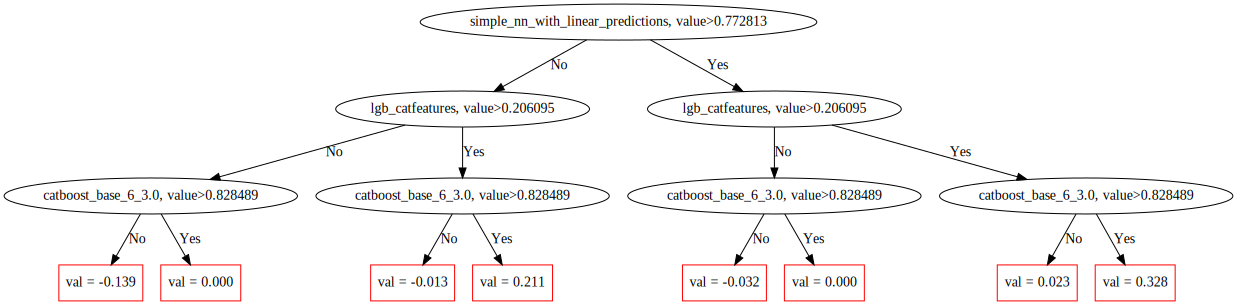

In [81]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [82]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,lgb_all,14.388914
1,catboost_base_6_3.0_catboost_anomaly_3_6.0_diff,12.446231
2,catboost_base_3_1.0_catboost_anomaly_3_6.0_diff,10.961921
3,catboost_base_6_3.0,10.534407
4,catboost_base_6_3.0_simple_nn_with_linear_pred...,9.361810
5,catboost_base_3_1.0,9.107421
6,lgb_all_catboost_anomaly_3_6.0_diff,7.348002
7,catboost_base_6_3.0_simple_nn_diff,4.643219
8,simple_nn_with_linear_predictions,3.707852
9,lgb_catfeatures,2.976878


In [83]:
worst_model = models[np.argmin(validation_scores)]
worst_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,lgb_all_catboost_anomaly_3_6.0_diff,44.516631
1,lgb_all,33.067422
2,autoencoder_catboost_8_1.0_lgb_all_diff,22.415947
3,catboost_base_6_3.0,0.000000
4,catboost_base_3_1.0,0.000000
5,autoencoder_catboost_8_1.0,0.000000
6,simple_nn,0.000000
7,lgb_catfeatures,0.000000
8,simple_nn_with_linear_predictions,0.000000
9,multihead_nn,0.000000


In [84]:
f_i = best_model.get_feature_importance(prettified=True)
important_features = f_i[f_i['Importances'] > 0]['Feature Id'].values

In [85]:
model_predictions_train = model_predictions_train[important_features]
model_predictions_test = model_predictions_test[important_features]

submission_pool = Pool(data=model_predictions_test[important_features], cat_features=cat_features)
train = model_predictions_train[important_features]

In [86]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train, labels):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)/3

Learning rate set to 0.057693
0:	learn: 0.9747834	test: 0.9773450	best: 0.9773450 (0)	total: 10.4ms	remaining: 10.4s
10:	learn: 0.9756355	test: 0.9787604	best: 0.9788508 (5)	total: 61.2ms	remaining: 5.5s
20:	learn: 0.9759685	test: 0.9785632	best: 0.9789372 (14)	total: 97.3ms	remaining: 4.53s
30:	learn: 0.9761023	test: 0.9784687	best: 0.9789372 (14)	total: 132ms	remaining: 4.12s
40:	learn: 0.9763348	test: 0.9784603	best: 0.9789372 (14)	total: 167ms	remaining: 3.91s
50:	learn: 0.9766279	test: 0.9782714	best: 0.9789372 (14)	total: 209ms	remaining: 3.9s
60:	learn: 0.9772924	test: 0.9778808	best: 0.9789372 (14)	total: 264ms	remaining: 4.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9789371981
bestIteration = 14

Shrink model to first 15 iterations.
Validation f1 0.9789371980676328
Learning rate set to 0.057693
0:	learn: 0.9751574	test: 0.9774131	best: 0.9774131 (0)	total: 4.01ms	remaining: 4.01s
10:	learn: 0.9755863	test: 0.9778846	best: 0.9778846 (10)	total: 40.3m

In [52]:
np.mean(validation_scores), np.std(validation_scores)

(0.9768210126623139, 0.0028145902755543446)

# Extra trees stack

In [5]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

In [10]:
features = model_predictions_test.columns

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [28]:
params = {
    'n_estimators':10,
    'random_state':0,
    'max_depth':3
}

In [70]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

Validation f1 0.9588048090523338
Validation f1 0.9582743988684582
Validation f1 0.9485411140583554


In [71]:
np.mean(validation_scores), np.std(validation_scores)

(0.9552067739930491, 0.004718304816670618)

### Limited features

In [14]:
features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]

model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [16]:
params = {
    'n_estimators':10,
    'random_state':0,
    'max_depth':3
}

In [17]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

Validation f1 0.9602192362093352
Validation f1 0.9609264497878359
Validation f1 0.946949602122016


In [18]:
np.mean(validation_scores), np.std(validation_scores)

(0.9560317627063957, 0.006428544076836778)

In [19]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values

In [20]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

Validation f1 0.9602192362093352
Validation f1 0.9586280056577087
Validation f1 0.9471264367816092


In [21]:
np.mean(validation_scores), np.std(validation_scores)

(0.9553245595495511, 0.0058332333147116)

# logistic regression stack

In [22]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = model_predictions_test.columns

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [23]:
params = {    
    'random_state':0,
    'penalty':'l2',
    'solver':'lbfgs',
    'max_iter':1000
}

In [24]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

Validation f1 0.9584512022630834
Validation f1 0.96004243281471
Validation f1 0.9465959328028294


In [25]:
np.mean(validation_scores), np.std(validation_scores)

(0.9550298559602076, 0.0059989609397810475)

### Limited features

In [26]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values
y = model_predictions_train['label'].values

In [27]:
params = {    
    'random_state':0,
    'penalty':'l2',
    'solver':'lbfgs',
    'max_iter':1000
}

In [28]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

Validation f1 0.958981612446959
Validation f1 0.9595120226308345
Validation f1 0.9474801061007958


In [29]:
np.mean(validation_scores), np.std(validation_scores)

(0.955324580392863, 0.005551105981692184)

In [30]:
model_predictions_train = pd.read_csv('stack_train.csv')
model_predictions_test = pd.read_csv('stack_test.csv')

features = [
    'catboost_base_6_3.0',
    'catboost_base_3_1.0',
    'autoencoder_catboost_8_1.0',
    'lgb_all',
    'simple_nn',
    'lgb_catfeatures',
    'simple_nn_with_linear_predictions',
    'multihead_nn',
    'catboost_anomaly_3_6.0'
]
y = model_predictions_train['label'].values
model_predictions_train = model_predictions_train[features]
model_predictions_test = model_predictions_test[features]

new_featuers = []

for i,col1 in enumerate(features):
        for col2 in features[i+1:]:
            col_name = f'{col1}_{col2}_diff'
            model_predictions_train[col_name] = model_predictions_train[col1] - model_predictions_train[col2]
            model_predictions_test[col_name] = model_predictions_test[col1] - model_predictions_test[col2]
            new_featuers.append(col_name)
            
features = features + new_featuers

train_X = model_predictions_train[features].values
test_X = model_predictions_test[features].values


In [31]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
models = []
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(train_X, y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    validation_score = f1_score(y_test, pred,average='micro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)    
    submission_preds += model.predict(test_X)/3

Validation f1 0.9588048090523338
Validation f1 0.9598656294200849
Validation f1 0.946949602122016


In [32]:
np.mean(validation_scores), np.std(validation_scores)

(0.9552066801981449, 0.005854675552048162)